In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.metrics import r2_score
import scipy.stats as stats
import numpy as np
import pandas as pd
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from adahessian import Adahessian, get_params_grad
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
all_qs= [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# Definition of the network
class Network(nn.Module):
    def __init__(self, indim):
        super(Network,self).__init__()
        self.fc1 = nn.Linear(indim,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,16)
        self.fc4= nn.Linear(16, 8)
        self.fc5= nn.Linear(8, 9)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x= F.relu(self.fc4(x))
        return self.fc5(x)

def tiltedLC(x, y, tau, h):
    e= y-x # errors
    ind= (torch.sign(e)+1)/2 # the division in the log-cosh is only about the origin
    quantFactor= (1-tau)*(1-ind) + tau*ind
    loss= quantFactor*torch.log(torch.cosh(e))
    loss= torch.mean(loss)
    return loss

def check_loss(x, y, tau): # the x,*args way to pass arguments to this function is an idiom for the scipy.optimize() library y = args[0][0]
    e = y-x
    # below I(e<0)
    ind = (torch.sign(-e)+1)/2
    loss = torch.mean(e*(tau-ind))
    return loss

def customLoss(y_true, y_pred, h):
    ind_losses = []
    for i,j in enumerate(all_qs):
        single_quantile_loss = tiltedLC(y_pred[i], y_true, j, h)
        # single_quantile_loss = tiltedLC(y_true[:,0],y_pred[:,i*4760:i*4760+4760], j, h)
        ind_losses.append(single_quantile_loss)
    zero = torch.Tensor([0]).to(device)
    # dummy1 = y_pred[:,1:] - y_pred[:,:-1]
    # dummy2 = penalty * torch.mean(torch.max(zero,-1.0 * dummy1))
    total_loss  = torch.mean(torch.stack(ind_losses))
    return total_loss

In [3]:
# generating the data
X = np.random.uniform(-1,1,5000).reshape(-1,1)
#Noise
E = np.random.normal(0,1,5000).reshape(-1,1)
Y = 5*np.sin(2*4*X) + E
pure_y = Y
og_mean = Y.mean()
og_std = Y.std()
Norm_Y = (Y-Y.mean())/Y.std()
y_binary = Y.copy()
y_binary[Y <= og_mean] = 0
y_binary[Y > og_mean] = 1
y_binary = y_binary.reshape(-1,1)
y_binary2 = np.concatenate([y_binary for i in range(9)], axis =1)

print("Number of class = 1:",np.count_nonzero(y_binary == 1))
print("Range of Y:",min(Y),"to",max(Y))
quantiles = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) # Quantiles we want to predict

# Loss function hyperparameters
mean_is = 0
std_is = 1
penalty = 1

model= Network(1)
optimizer= optim.Adam(model.parameters(), lr=0.001)
device= ('cuda' if torch.cuda.is_available() else 'cpu')
h= 0.4

Number of class = 1: 2430
Range of Y: [-7.90443404] to [8.30520671]


In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y_binary2, test_size=0.2, random_state=42)
train_data= torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float())
test_data= torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).float())
trainLoader= torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True) 
testLoader= torch.utils.data.DataLoader(test_data, batch_size=512, shuffle=True)

In [5]:
def train(model,loader, epochs):
    train_preds_Q = []
    train_labels = []
    model.train()
    
    for epoch in range(epochs):
        for i, j in enumerate(loader):
            inputs,labels = j[0],j[1]
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            op_qs = model(inputs)
            lossQ = customLoss(op_qs, labels, h)
            print(lossQ.item())
            lossQ.backward()
            optimizer.step()

In [6]:
train(model, trainLoader, 100)

0.0750541165471077
0.07021373510360718
0.06298109143972397
0.10734766721725464
0.12334448844194412
0.10213997215032578
0.09957587718963623
0.13865019381046295
0.13583983480930328
0.1445898860692978
0.064084991812706
0.10018882900476456
0.09315044432878494
0.07005494832992554
0.11716394871473312
0.17939379811286926
0.06286563724279404
0.0563516691327095
0.13324949145317078
0.13276101648807526
0.13384610414505005
0.19122157990932465
0.10007253289222717
0.08780171722173691
0.061194565147161484
0.08413884043693542
0.11671817302703857
0.13233666121959686
0.08197174966335297
0.0912487804889679
0.07879108935594559
0.15581655502319336
0.11104805022478104
0.05924505740404129
0.11413657665252686
0.07586362212896347
0.10920220613479614
0.045935820788145065
0.13612346351146698
0.12704622745513916
0.06593748927116394
0.057098355144262314
0.046779878437519073
0.0461110956966877
0.09999371320009232
0.07185018062591553
0.13122627139091492
0.04231252148747444
0.04486292973160744
0.09434334933757782
0.0

In [7]:
model.eval()
outputs= [[0 for i in range(488)] for i in range(9)]
ops= [[] for i in range(9)]

j= 0
for inputs, labels in testLoader:
    output= model(inputs)
    j+= 1

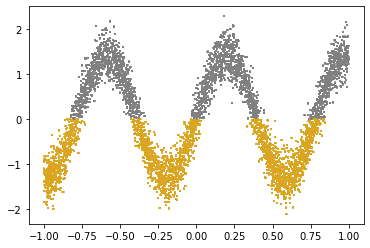

In [10]:
indices = X.argsort(axis=None)
color_arr = []
for i in Norm_Y[indices]:
    if i<=0:
        color_arr.append("goldenrod")
    else:
        color_arr.append("grey")
plt.scatter(X[indices], Norm_Y[indices],5,c=color_arr, marker="+")
# plt.plot(X[indices][:488],outputs[1], label="Q:0.2",c="tomato", linewidth=3)
#[x.cpu().detach().numpy() for x in outputs[1]]